The following experiment demonstrates that we can customize optimizer for different layers, where different settings such various learning rates are allowed.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import copy
import random
import numpy as np

class CustomAdamW(torch.optim.Optimizer):
    """
    Custom Adam class 
    """
    # Define standard Hyperparameters 
    def __init__(self, params, lr=0.01, beta1 =0.9, beta2 = 0.999, eps=1e-8, weight_decay=0):
         
        # invalid input errors
        if lr<= 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if eps<= 0.0:
            raise ValueError(f"eps needs to be a positive value")
        
        # define a dictionary for hyperparameters
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2 , eps=eps, weight_decay=weight_decay)
        super(CustomAdamW, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        """Performs a single adam optimization step."""
        print(f"there are {len(self.param_groups)} parameter groups")
        for group in self.param_groups:
            lr = group['lr']
            beta1 = group['beta1']  
            beta2 = group['beta2']
            eps = group['eps']
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]

                # State Initialization to save parameter information over iterations
                if len(state) == 0:
                    state['step'] = 0
                    # m_t: Biased first moment estimate (like momentum)
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # v_t: Biased second raw moment estimate (adaptive learning rate)
                    state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                # Get state variables for the current parameter
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                
                # Increment step counter t
                state['step'] += 1
                t = state['step']
                # --- Core AdamW Logic ---

                # 1. Update the biased estimates for m_t and v_t
                exp_avg.mul_(beta1).add_(p.grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(p.grad, p.grad, value=1 - beta2)

                # 2. Calculate the NUMERATOR: The bias-corrected first moment (m_hat_t)
                bias_correction1 = 1 - beta1 ** t
                numerator = exp_avg / bias_correction1
                
                # 3. Calculate the DENOMINATOR: The bias-corrected second moment (sqrt(v_hat_t)) + eps
                bias_correction2 = 1 - beta2 ** t
                # First, get v_hat_t
                v_hat_t = exp_avg_sq / bias_correction2
                # Then, calculate the full denominator
                denominator = v_hat_t.sqrt().add(eps)

                # 4. Calculate the final update amount
                update_step = numerator / denominator

                # 5. Apply the final update to the parameter
                # new_weight = old_weight - lr * (numerator / denominator)
                if weight_decay != 0:
                    p.mul_(1 - lr * weight_decay)
                p.add_(-lr*update_step)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set a seed so both models start with the same random weights
# --- Ensure Full Reproducibility ---
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# for GPU reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

subset_indices = list(range(int(len(trainset)))) 
trainset_subset = torch.utils.data.Subset(trainset, subset_indices)
trainloader = torch.utils.data.DataLoader(trainset_subset, batch_size=64,
                                          shuffle=False, num_workers=2)

# --- Model ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# --- Data ---
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# --- Model + Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

# --- Two Parameter Groups ---
param_groups = [
    {"params": list(model.conv1.parameters()) + list(model.conv2.parameters()), "lr": 1e-3},
    {"params": list(model.fc1.parameters()) + list(model.fc2.parameters()), "lr": 1e-2},
]

optimizer = CustomAdamW(param_groups, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# --- Training Loop (1 epoch for demo) ---
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    break  # just run 1 batch for demo

print("One training step done with 2 param groups.")


Using device: cuda:0
Files already downloaded and verified
Files already downloaded and verified
there are 2 parameter groups
One training step done with 2 param groups.


We compare our own implementation of AdamW with built-in AdamW and Adam, one can find our customized version can be even superior to the counnterparts.

Using device: cuda:0
Files already downloaded and verified
--- Training Custom AdamW ---
Epoch [1/15], Loss: 1.5544
Epoch [2/15], Loss: 1.2059
Epoch [3/15], Loss: 1.0528
Epoch [4/15], Loss: 0.9500
Epoch [5/15], Loss: 0.8719
Epoch [6/15], Loss: 0.8060
Epoch [7/15], Loss: 0.7534
Epoch [8/15], Loss: 0.7076
Epoch [9/15], Loss: 0.6659
Epoch [10/15], Loss: 0.6279
Epoch [11/15], Loss: 0.5956
Epoch [12/15], Loss: 0.5695
Epoch [13/15], Loss: 0.5419
Epoch [14/15], Loss: 0.5152
Epoch [15/15], Loss: 0.4928
Finished training Custom AdamW. Total time: 74.62s

--- Training PyTorch AdamW ---
Epoch [1/15], Loss: 1.5595
Epoch [2/15], Loss: 1.2158
Epoch [3/15], Loss: 1.0660
Epoch [4/15], Loss: 0.9642
Epoch [5/15], Loss: 0.8873
Epoch [6/15], Loss: 0.8239
Epoch [7/15], Loss: 0.7710
Epoch [8/15], Loss: 0.7241
Epoch [9/15], Loss: 0.6830
Epoch [10/15], Loss: 0.6463
Epoch [11/15], Loss: 0.6160
Epoch [12/15], Loss: 0.5981
Epoch [13/15], Loss: 0.5739
Epoch [14/15], Loss: 0.5484
Epoch [15/15], Loss: 0.5233
Finish

([<matplotlib.axis.XTick at 0x7fdd84714b20>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15')])

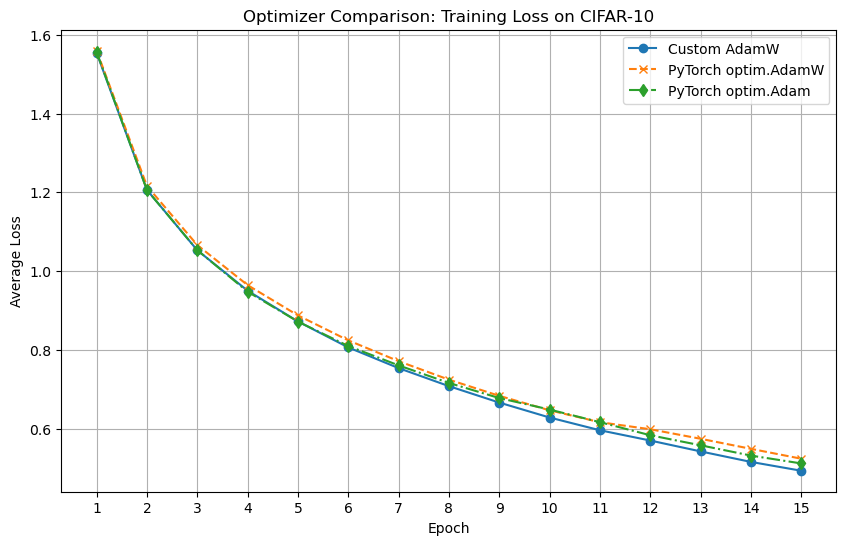

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import copy
import random
import numpy as np

class CustomAdamW(torch.optim.Optimizer):
    """
    Custom Adam class 
    """
    # Define standard Hyperparameters 
    def __init__(self, params, lr=0.01, beta1 =0.9, beta2 = 0.999, eps=1e-8, weight_decay=0):
         
        # invalid input errors
        if lr<= 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if eps<= 0.0:
            raise ValueError(f"eps needs to be a positive value")
        
        # define a dictionary for hyperparameters
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2 , eps=eps, weight_decay=weight_decay)
        super(CustomAdamW, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        """Performs a single adam optimization step."""
        #print(f"there are {len(self.param_groups)} parameter groups")
        for group in self.param_groups:
            lr = group['lr']
            beta1 = group['beta1']  
            beta2 = group['beta2']
            eps = group['eps']
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]

                # State Initialization to save parameter information over iterations
                if len(state) == 0:
                    state['step'] = 0
                    # m_t: Biased first moment estimate (like momentum)
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # v_t: Biased second raw moment estimate (adaptive learning rate)
                    state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                # Get state variables for the current parameter
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                
                # Increment step counter t
                state['step'] += 1
                t = state['step']                               
                # --- Core AdamW Logic ---

                # 1. Update the biased estimates for m_t and v_t
                exp_avg.mul_(beta1).add_(p.grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(p.grad, p.grad, value=1 - beta2)

                # 2. Calculate the NUMERATOR: The bias-corrected first moment (m_hat_t)
                bias_correction1 = 1 - beta1 ** t
                numerator = exp_avg / bias_correction1
                
                # 3. Calculate the DENOMINATOR: The bias-corrected second moment (sqrt(v_hat_t)) + eps
                bias_correction2 = 1 - beta2 ** t
                # First, get v_hat_t
                v_hat_t = exp_avg_sq / bias_correction2
                # Then, calculate the full denominator
                denominator = v_hat_t.sqrt().add(eps)

                # 4. Calculate the final update amount
                update_step = numerator / denominator

                # 5. Apply the final update to the parameter
                # new_weight = old_weight - lr * (numerator / denominator)
                if weight_decay != 0:
                    p.mul_(1 - lr * weight_decay)
                p.add_(-lr*update_step)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set a seed so both models start with the same random weights
# --- Ensure Full Reproducibility ---
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# for GPU reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

subset_indices = list(range(int(len(trainset)))) 
trainset_subset = torch.utils.data.Subset(trainset, subset_indices)
trainloader = torch.utils.data.DataLoader(trainset_subset, batch_size=64,
                                          shuffle=False, num_workers=2)

# --- Model ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# --- Create two identical models ---
model_custom = SimpleCNN().to(device)
model_pytorch = copy.deepcopy(model_custom).to(device)
model_pytorch1 = copy.deepcopy(model_custom).to(device)

LEARNING_RATE = 0.001
EPOCHS = 15
criterion = nn.CrossEntropyLoss()

# --- Instantiate Optimizers ---
optimizer_custom = CustomAdamW(model_custom.parameters(), lr=LEARNING_RATE)
optimizer_pytorch = optim.AdamW(model_pytorch.parameters(), lr=LEARNING_RATE)
optimizer_pytorch1 = optim.Adam(model_pytorch1.parameters(), lr=LEARNING_RATE)


def train_model(model, optimizer, model_name):
    """A helper function to train a given model."""
    print(f"--- Training {model_name} ---")
    start_time = time.time()
    losses = []
    model.train() # Set model to training mode
    for epoch in range(EPOCHS):
        running_loss = 0.0
        size = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()*labels.shape[0]
            size += labels.shape[0]
        avg_loss = running_loss / size
        #print(f"size is {size}")
        #print(f"len(trainloader) is {len(trainloader)}")
        losses.append(avg_loss)
        print(f'Epoch [{epoch + 1}/{EPOCHS}], Loss: {avg_loss:.4f}')
    
    end_time = time.time()
    print(f'Finished training {model_name}. Total time: {end_time - start_time:.2f}s\n')
    return losses


custom_adamw_losses = train_model(model_custom, optimizer_custom, "Custom AdamW")
pytorch_adamw_losses = train_model(model_pytorch, optimizer_pytorch, "PyTorch AdamW")
pytorch_adam_losses = train_model(model_pytorch1, optimizer_pytorch1, "PyTorch Adam")


plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), custom_adamw_losses, marker='o', linestyle='-', label='Custom AdamW')
plt.plot(range(1, EPOCHS + 1), pytorch_adamw_losses, marker='x', linestyle='--', label='PyTorch optim.AdamW')
plt.plot(range(1, EPOCHS + 1), pytorch_adam_losses, marker='d', linestyle='-.', label='PyTorch optim.Adam')
plt.title('Optimizer Comparison: Training Loss on CIFAR-10')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.xticks(range(1, EPOCHS + 1))

\begin{array}{c|c|c} 
\hline 
\text{Tiger} & \text{Lion} & \text{AdamW} \\ 
\hline 
{\begin{aligned} 
&\boldsymbol{m}_t = \beta \boldsymbol{m}_{t-1} + \left(1 - \beta\right) \boldsymbol{g}_t \\ 
&\boldsymbol{\theta}_t = \boldsymbol{\theta}_{t-1} - \eta_t \left[\text{sign}(\boldsymbol{m}_t) \color{skyblue}{ + \lambda_t \boldsymbol{\theta}_{t-1}}\right] \\ 
\end{aligned}} & 
{\begin{aligned} 
&\boldsymbol{u}_t = \text{sign}\big(\beta_1 \boldsymbol{m}_{t-1} + \left(1 - \beta_1\right) \boldsymbol{g}_t\big) \\ 
&\boldsymbol{\theta}_t = \boldsymbol{\theta}_{t-1} - \eta_t (\boldsymbol{u}_t \color{skyblue}{ + \lambda_t \boldsymbol{\theta}_{t-1}}) \\ 
&\boldsymbol{m}_t = \beta_2 \boldsymbol{m}_{t-1} + \left(1 - \beta_2\right) \boldsymbol{g}_t 
\end{aligned}} & 
{\begin{aligned} 
&\boldsymbol{m}_t = \beta_1 \boldsymbol{m}_{t-1} + \left(1 - \beta_1\right) \boldsymbol{g}_t\\ 
&\boldsymbol{v}_t = \beta_2 \boldsymbol{v}_{t-1} + \left(1 - \beta_2\right) \boldsymbol{g}_t^2\\ 
&\hat{\boldsymbol{m}}_t = \boldsymbol{m}_t\left/\left(1 - \beta_1^t\right)\right.\\ 
&\hat{\boldsymbol{v}}_t = \boldsymbol{v}_t\left/\left(1 - \beta_2^t\right)\right.\\ 
&\boldsymbol{u}_t =\hat{\boldsymbol{m}}_t\left/\left(\sqrt{\hat{\boldsymbol{v}}_t} + \epsilon\right)\right.\\ 
&\boldsymbol{\theta}_t = \boldsymbol{\theta}_{t-1} - \eta_t (\boldsymbol{u}_t \color{skyblue}{ + \lambda_t \boldsymbol{\theta}_{t-1}}) 
\end{aligned}} \\ 
\hline 
\end{array}

We list different optimizers' update as above. Please follow the implementation of AdamW above and complete Lion and Tiger optimizers. One should keep in mind that of all the three optimizers above, AdamW needs maintain three tables: $\boldsymbol{\theta}, \boldsymbol{m}, \boldsymbol{v}$ while the rest only need maintain two. Besides, AdamW involves with division and square root operation which can be time-consuming as well.

In [ ]:
## TODO: implement Lion Optimizer
class Lion(torch.optim.Optimizer):

In [ ]:
## TODO: implement Tiger Optimizer
class Tiger(torch.optim.Optimizer):

In [ ]:
## TODO: compare the convergence performance of the above three optimizers on the defined network above for CIFAR10
## TODO: and check time consumption